# 📊 XRD CNN Model - Detailed Error Analysis with Visualization

Comprehensive evaluation with:
- Top-K worst cases with **rocking curves** and **deformation profiles**
- Binning analysis with visual examples
- Parameter context on all plots

In [20]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from importlib import reload

import xrd
import helpers as h
import model_common

# Reload modules
reload(xrd)
reload(h)
reload(model_common)

from model_common import (
    XRDRegressor,
    NormalizedXRDDataset,
    load_dataset,
    denorm_params,
    get_device,
    PARAM_NAMES,
    RANGES
)

# Seaborn style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

print("✅ Imports successful")

✅ Imports successful


## 1️⃣ Configuration

In [21]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Dataset and model paths
DATA_PATH = "datasets/dataset_10000_dl100_7d.pkl"
MODEL_PATH = "checkpoints/dataset_10000_dl100_7d_v3.pt"

# Analysis parameters
TOP_K = 5  # Number of worst cases to visualize (grid gets big!)
BIN_EXAMPLES = 2  # Examples per bin (best + worst)
USE_LOG_SPACE = True  # Must match training setting
BATCH_SIZE = 256
DL = 100e-8  # For curve generation (must match dataset)

print(f"📦 Dataset: {DATA_PATH}")
print(f"🧠 Model: {MODEL_PATH}")
print(f"🔬 Top-K: {TOP_K}")
print(f"📊 Log-space: {USE_LOG_SPACE}")
print(f"📐 dl: {DL*1e8:.0f} Å")

📦 Dataset: datasets/dataset_10000_dl100_7d.pkl
🧠 Model: checkpoints/dataset_10000_dl100_7d_v3.pt
🔬 Top-K: 5
📊 Log-space: True
📐 dl: 100 Å


## 2️⃣ Load Model & Run Predictions

In [22]:
# Setup
device = get_device()
print(f"✓ Using device: {device}")

# Load dataset
X, Y = load_dataset(Path(DATA_PATH))
print(f"✓ Loaded dataset: X shape {X.shape}, Y shape {Y.shape}")

# Load model
print(f"\n📦 Loading model from: {MODEL_PATH}")
ckpt = torch.load(MODEL_PATH, map_location=device, weights_only=False)
model = XRDRegressor().to(device)
model.load_state_dict(ckpt["model"])
model.eval()

if "epoch" in ckpt:
    print(f"   Checkpoint: epoch {ckpt['epoch']}, val_loss {ckpt.get('val_loss', 'N/A')}")

# Create dataset
ds = NormalizedXRDDataset(X, Y, log_space=USE_LOG_SPACE, train=False)
dl = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE)

# Run predictions
print(f"\n🔮 Running predictions on {len(ds)} samples...")
preds = []

with torch.no_grad():
    for y, _ in tqdm(dl, desc="Evaluating", unit="batch"):
        p = model(y.to(device))
        preds.append(p.cpu())

P = torch.cat(preds, dim=0)
Theta_hat = denorm_params(P)

print("✅ Predictions complete!")

✓ Using MPS (Apple Silicon)
✓ Using device: mps
✓ Applying crop_params: Y[:, 50:701]
  Before crop: (10000, 701)
  After crop:  (10000, 651)
✓ Loaded dataset from datasets/dataset_10000_dl100_7d.pkl
  X shape: (10000, 7)  Y shape: (10000, 651)
✓ Loaded dataset: X shape torch.Size([10000, 7]), Y shape torch.Size([10000, 651])

📦 Loading model from: checkpoints/dataset_10000_dl100_7d_v3.pt
   Checkpoint: epoch 19, val_loss 0.02503485208749771

🔮 Running predictions on 10000 samples...


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.81batch/s]

✅ Predictions complete!


## 3️⃣ Calculate Errors & Basic Stats

In [28]:
# Calculate errors
abs_err = torch.abs(Theta_hat - X)  # [N, P]
rel_err = abs_err / (torch.abs(X) + 1e-12)  # Relative error

# MAE per parameter
mae = abs_err.mean(dim=0)

print(f"📊 Overall MAE per parameter:")
print(f"{'='*70}")
for j, name in enumerate(PARAM_NAMES):
    print(f"   {name:<8}: {mae[j]:.6e} ({rel_err[:, j].mean().item()*100:.2f}% avg relative error)")
print(f"{'='*70}")

📊 Overall MAE per parameter:
   Dmax1   : 1.689375e-03 (26.23% avg relative error)
   D01     : 2.327234e-03 (106.82% avg relative error)
   L1      : 7.228976e-06 (18.63% avg relative error)
   Rp1     : 3.921582e-06 (70.75% avg relative error)
   D02     : 2.729073e-03 (57.18% avg relative error)
   L2      : 6.537688e-06 (38.69% avg relative error)
   Rp2     : 1.526906e-05 (158574700.00% avg relative error)


## 4️⃣ Helper: Visualize Single Sample

In [29]:
def plot_sample_comparison(true_params, pred_params, sample_idx, ax_curve, ax_profile, dl=100e-8):
    """
    Plot rocking curve and deformation profile for one sample.
    
    Args:
        true_params: numpy array [7]
        pred_params: numpy array [7]
        sample_idx: sample index (for title)
        ax_curve: matplotlib axis for rocking curve
        ax_profile: matplotlib axis for deformation profile
        dl: sublayer thickness for curve generation
    """
    # Generate curves
    true_curve, true_profile = xrd.compute_curve_and_profile(true_params.tolist(), dl=dl)
    pred_curve, pred_profile = xrd.compute_curve_and_profile(pred_params.tolist(), dl=dl)
    
    # Calculate errors
    errors = pred_params - true_params
    rel_errors = errors / (np.abs(true_params) + 1e-12) * 100
    
    # === ROCKING CURVE ===
    ax_curve.plot(true_curve.X_DeltaTeta, true_curve.Y_R_vseZ, 
                  label='True', color='C0', linestyle='-', linewidth=2)
    ax_curve.plot(pred_curve.X_DeltaTeta, pred_curve.Y_R_vseZ, 
                  label='Predicted', color='orange', linestyle='--', linewidth=2, alpha=0.8)
    
    # ax_curve.set_xlim(-100, 3200)
    # ax_curve.set_ylim(0, 0.02)
    ax_curve.set_yscale('log')
    ax_curve.set_xlabel('Δθ (arcsec)', fontsize=9)
    ax_curve.set_ylabel('Intensity', fontsize=9)
    ax_curve.legend(fontsize=8, loc='upper right')
    ax_curve.grid(True, alpha=0.3)
    
    # Title with sample index
    ax_curve.set_title(f'Sample #{sample_idx:05d}: Rocking Curve', fontsize=10, fontweight='bold')
    
    # === DEFORMATION PROFILE ===
    ax_profile.plot(true_profile.X, true_profile.total_Y, 
                    label='True', color='C0', linestyle='-', linewidth=2)
    ax_profile.plot(pred_profile.X, pred_profile.total_Y, 
                    label='Predicted', color='orange', linestyle='--', linewidth=2, alpha=0.8)
    
    ax_profile.set_xlabel('Depth (cm)', fontsize=9)
    ax_profile.set_ylabel('Deformation', fontsize=9)
    ax_profile.legend(fontsize=8, loc='upper right')
    ax_profile.grid(True, alpha=0.3)
    ax_profile.set_title('Deformation Profile', fontsize=10, fontweight='bold')
    
    # === ADD PARAMETER INFO AS TEXT ===
    # Format parameters using helper
    true_str = h.fparam(arr=true_params)
    pred_str = h.fparam(arr=pred_params)
    
    # Add text box below plots
    info_text = (
        f"TRUE: {true_str}\n"
        f"PRED: {pred_str}\n"
        f"ERROR %: "
    )
    
    # Add individual parameter errors
    err_parts = []
    for i, name in enumerate(PARAM_NAMES):
        err_parts.append(f"{name}={rel_errors[i]:+.1f}%")
    info_text += ", ".join(err_parts)
    
    # Add text below the profile plot
    ax_profile.text(0.5, -0.35, info_text, 
                    transform=ax_profile.transAxes,
                    fontsize=7, 
                    verticalalignment='top',
                    horizontalalignment='center',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3),
                    family='monospace')

print("✅ Helper function defined: plot_sample_comparison()")

✅ Helper function defined: plot_sample_comparison()


## 5️⃣ Top-K Worst Cases (Grid Visualization)


🔴 TOP 5 WORST PREDICTIONS FOR Rp2

✅ Saved: topk_worst_Rp2.png


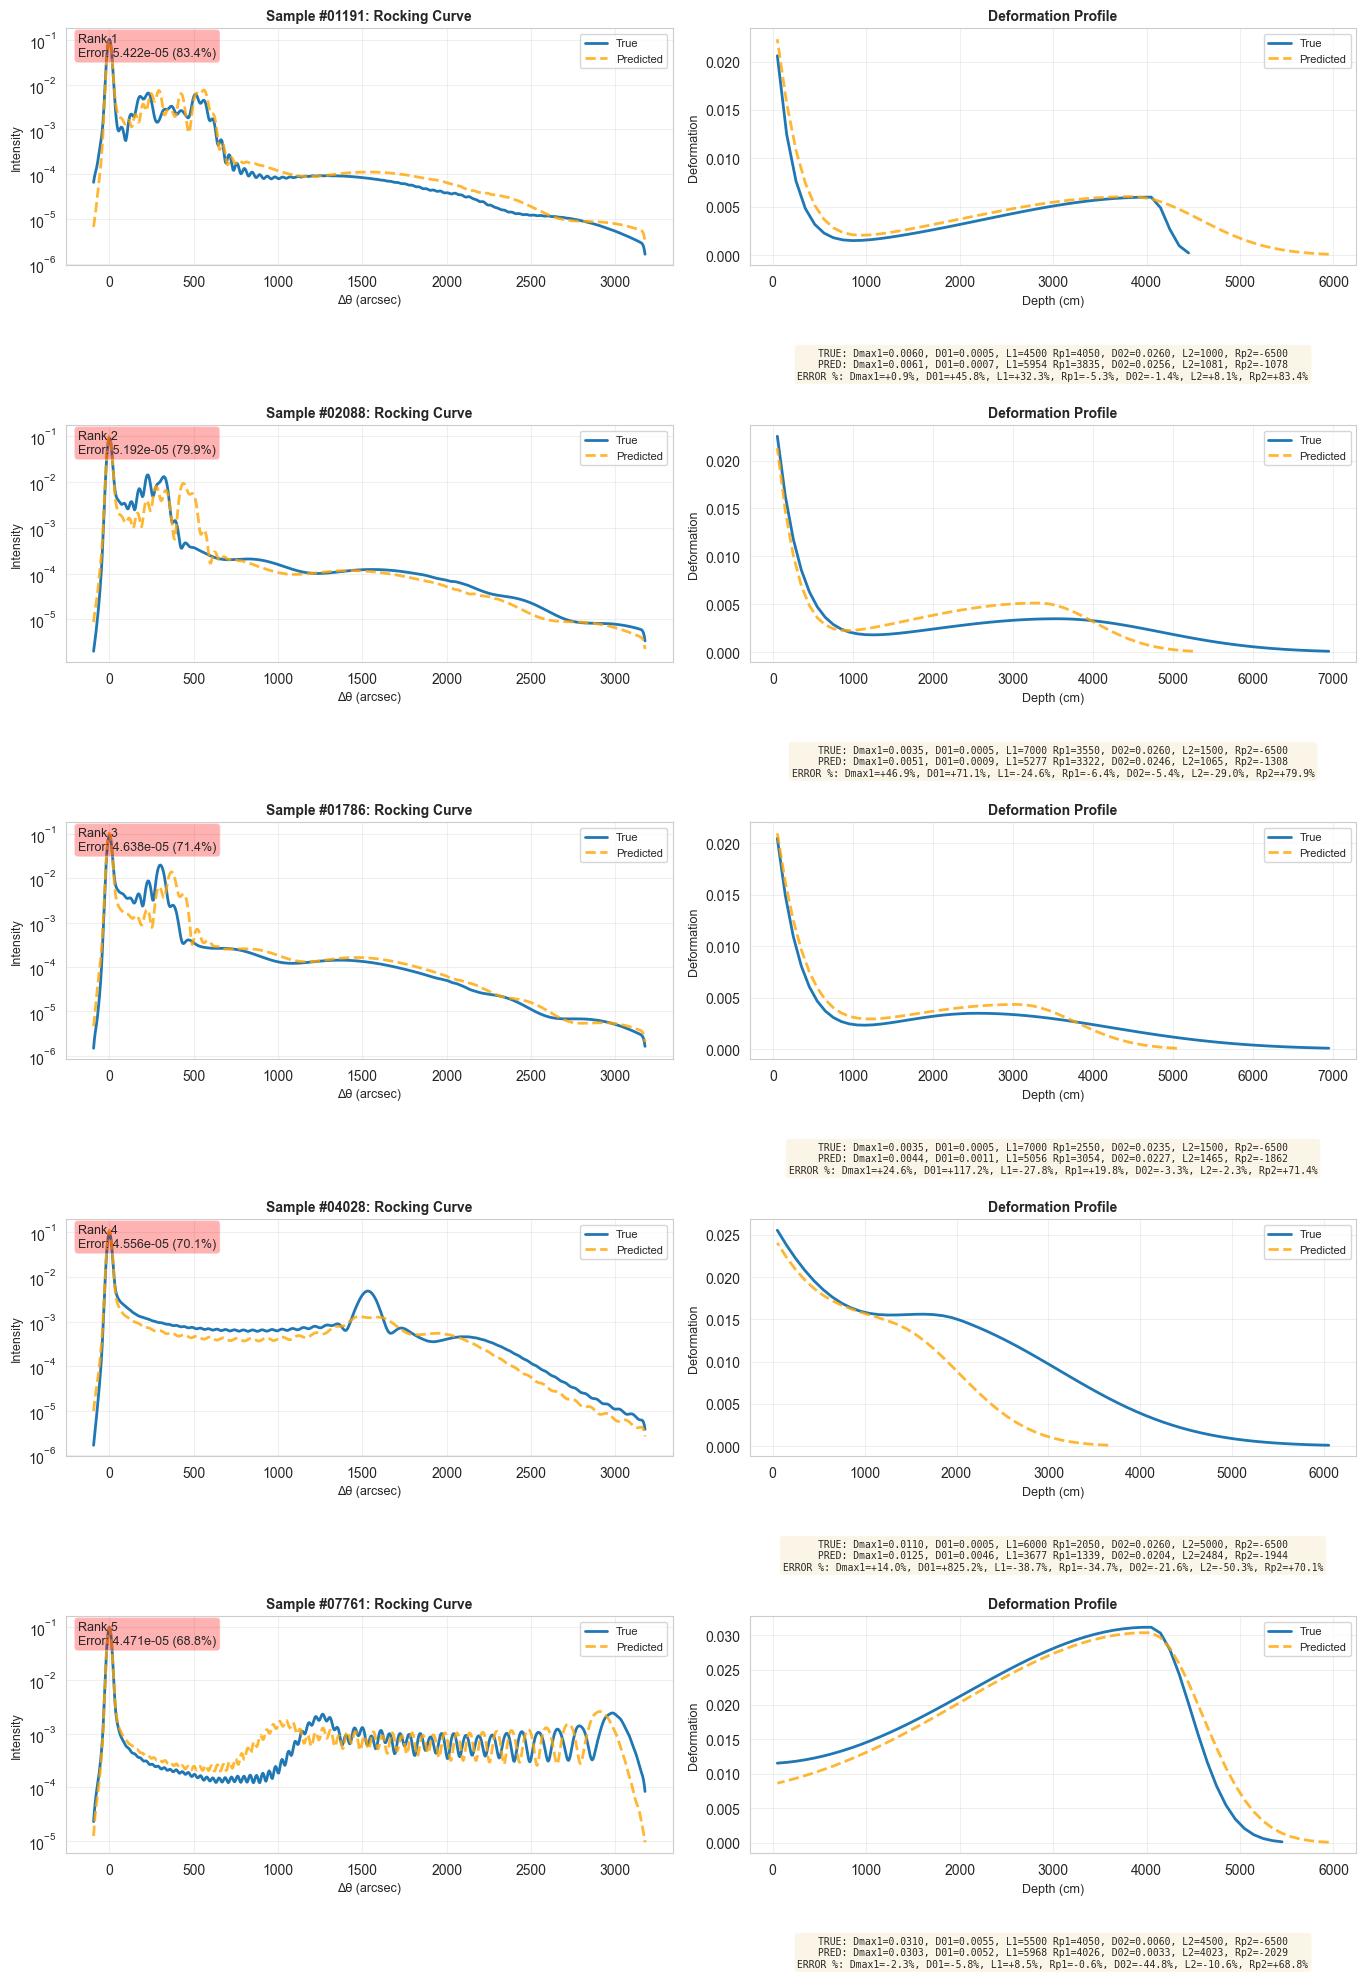


🔴 TOP 5 WORST PREDICTIONS FOR L2

✅ Saved: topk_worst_L2.png


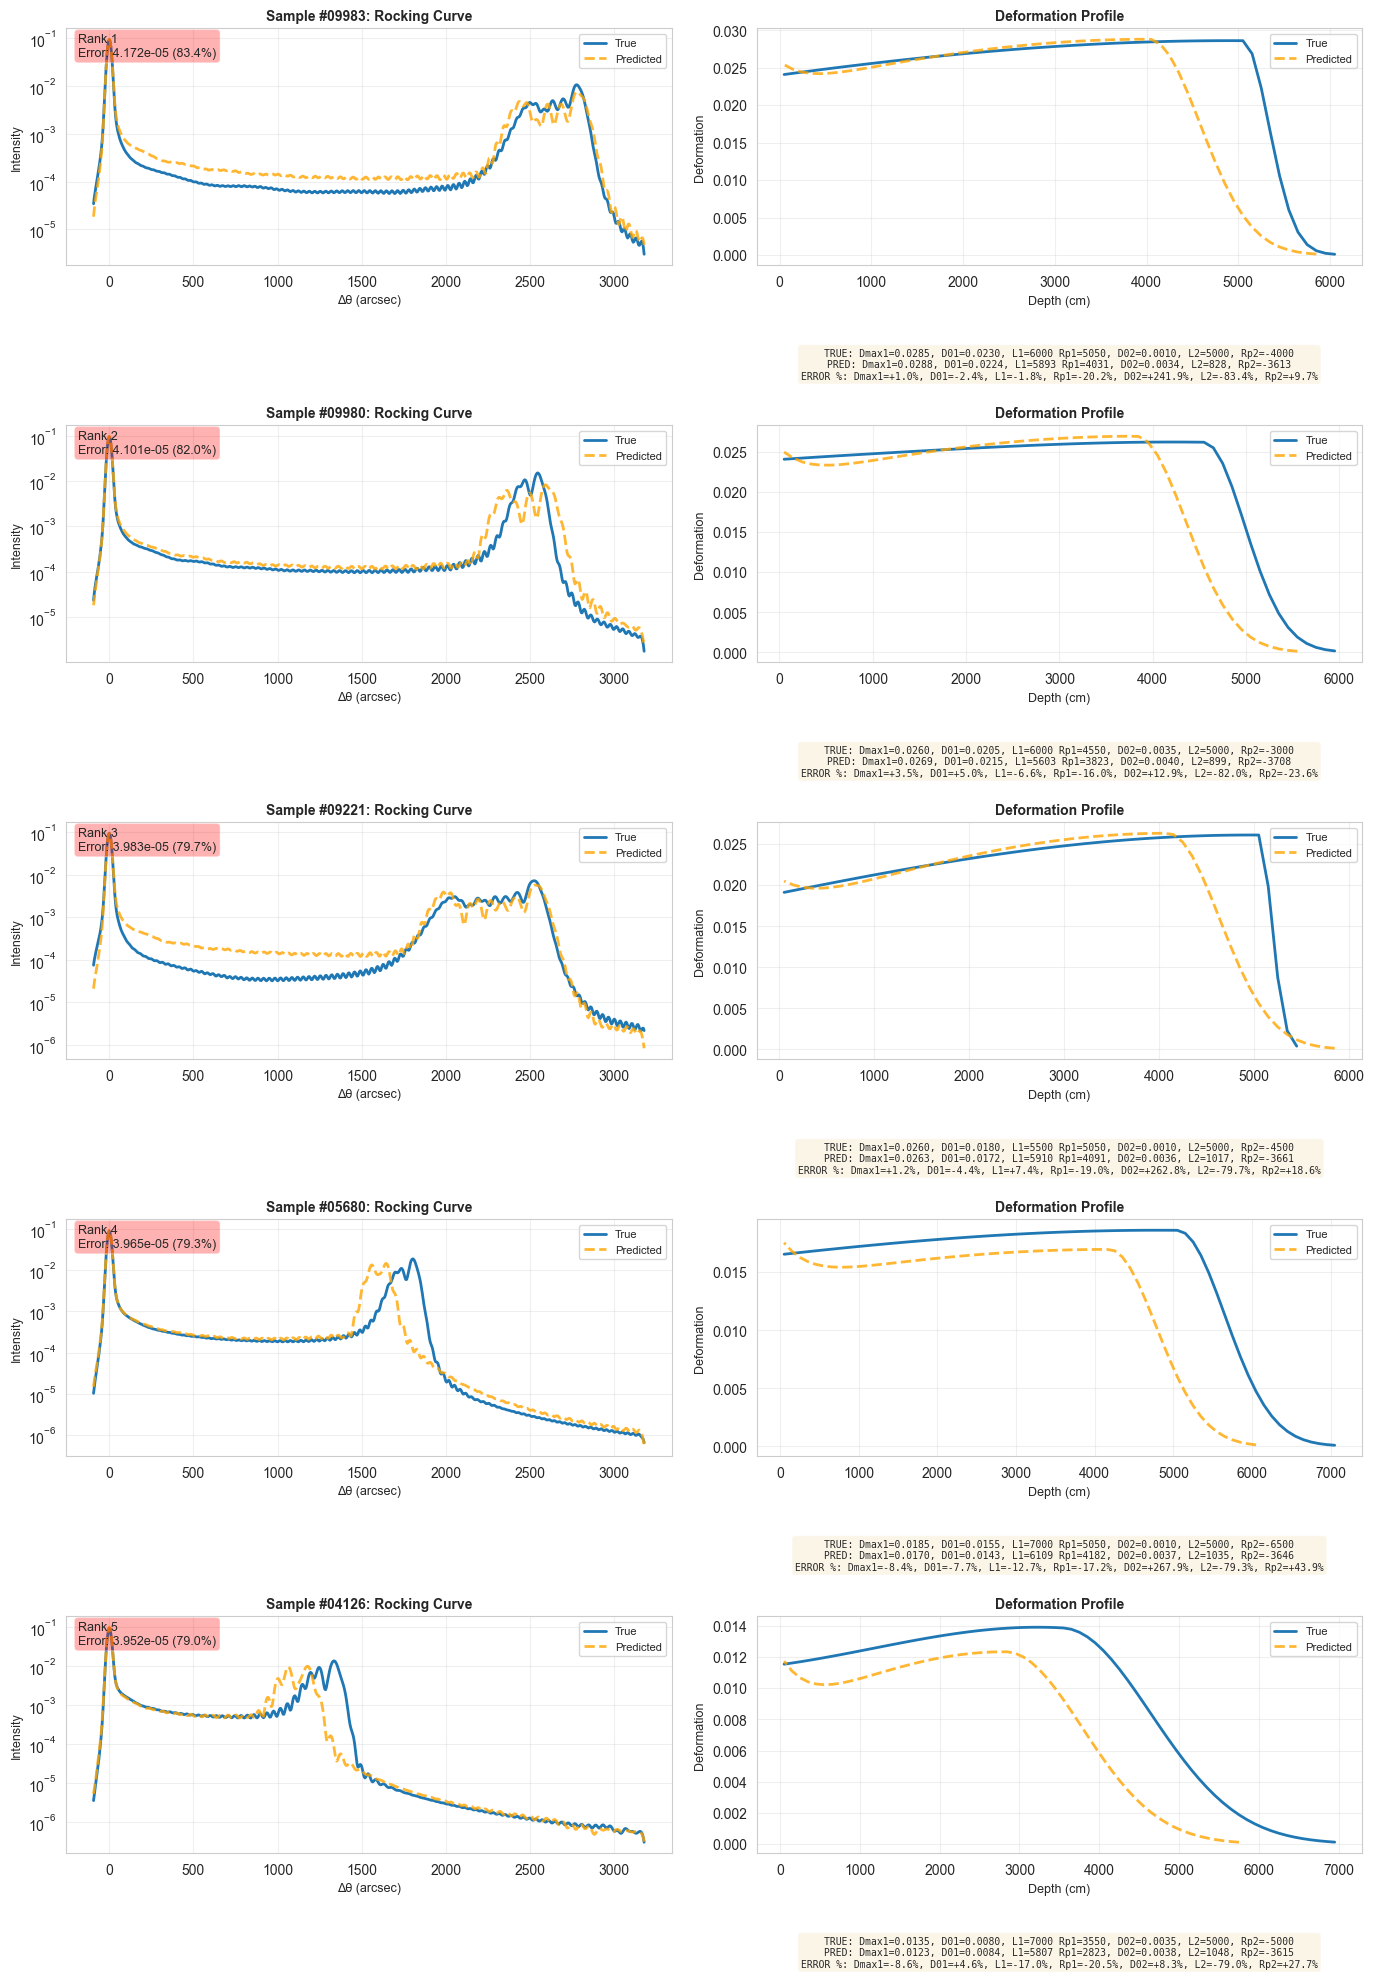

In [ ]:
def show_topk_worst_grid(X, Theta_hat, abs_err, param_name, k=5, dl=100e-8):
    """
    Show top-K worst predictions for a parameter with visual comparison.
    Grid layout: K rows x 2 columns (curve + profile)
    """
    # Find top-K worst indices for this parameter
    param_idx = PARAM_NAMES.index(param_name)
    errors = abs_err[:, param_idx]
    worst_indices = torch.argsort(errors, descending=True)[:k]
    
    print(f"\n{'='*80}")
    print(f"🔴 TOP {k} WORST PREDICTIONS FOR {param_name}")
    print(f"{'='*80}\n")
    
    # Create grid: k rows x 2 columns
    fig, axes = plt.subplots(k, 2, figsize=(14, 4*k))
    if k == 1:
        axes = axes.reshape(1, -1)
    
    for rank, idx in enumerate(worst_indices.tolist()):
        true_params = X[idx].numpy()
        pred_params = Theta_hat[idx].numpy()
        
        # Get axes for this row
        ax_curve = axes[rank, 0]
        ax_profile = axes[rank, 1]
        
        # Plot comparison
        plot_sample_comparison(true_params, pred_params, idx, ax_curve, ax_profile, dl=dl)
        
        # Add rank number to curve plot
        error_val = errors[idx].item()
        rel_error = (error_val / (abs(true_params[param_idx]) + 1e-12)) * 100
        ax_curve.text(0.02, 0.98, f"Rank {rank+1}\nError: {error_val:.3e} ({rel_error:.1f}%)",
                      transform=ax_curve.transAxes,
                      fontsize=9, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
    
    plt.tight_layout()
    filename = f'topk_worst_{param_name}.png'
    # plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"✅ Saved: {filename}")
    plt.show()

# Show for all parameters (or select specific ones)
# WARNING: This generates many plots! Start with 1-2 parameters
PARAMS_TO_ANALYZE = ['Rp2', 'L2']  # Most challenging parameters
# PARAMS_TO_ANALYZE = PARAM_NAMES  # Uncomment to analyze all

for param_name in PARAMS_TO_ANALYZE:
    show_topk_worst_grid(X, Theta_hat, abs_err, param_name, k=TOP_K, dl=DL)

## 6️⃣ Binning Analysis with Visual Examples


📦 BINNING ANALYSIS: L1 (grouped into 3 bins)


LOW bin (5.000e-06 to 2.667e-05):
  Samples: 1836
  Avg error: 7.235709e-06
  ✅ Saved: bin_L1_LOW.png


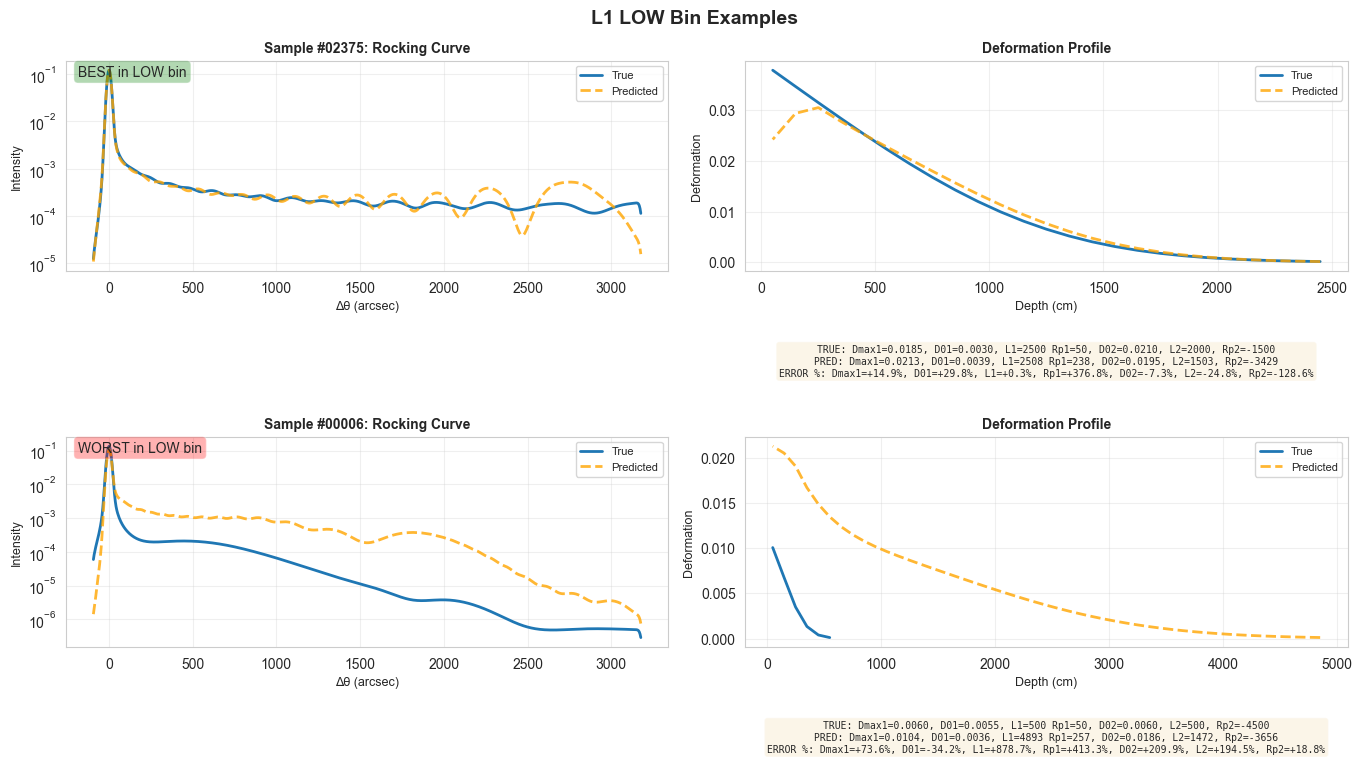


MEDIUM bin (2.667e-05 to 4.833e-05):
  Samples: 4087
  Avg error: 6.978205e-06
  ✅ Saved: bin_L1_MEDIUM.png


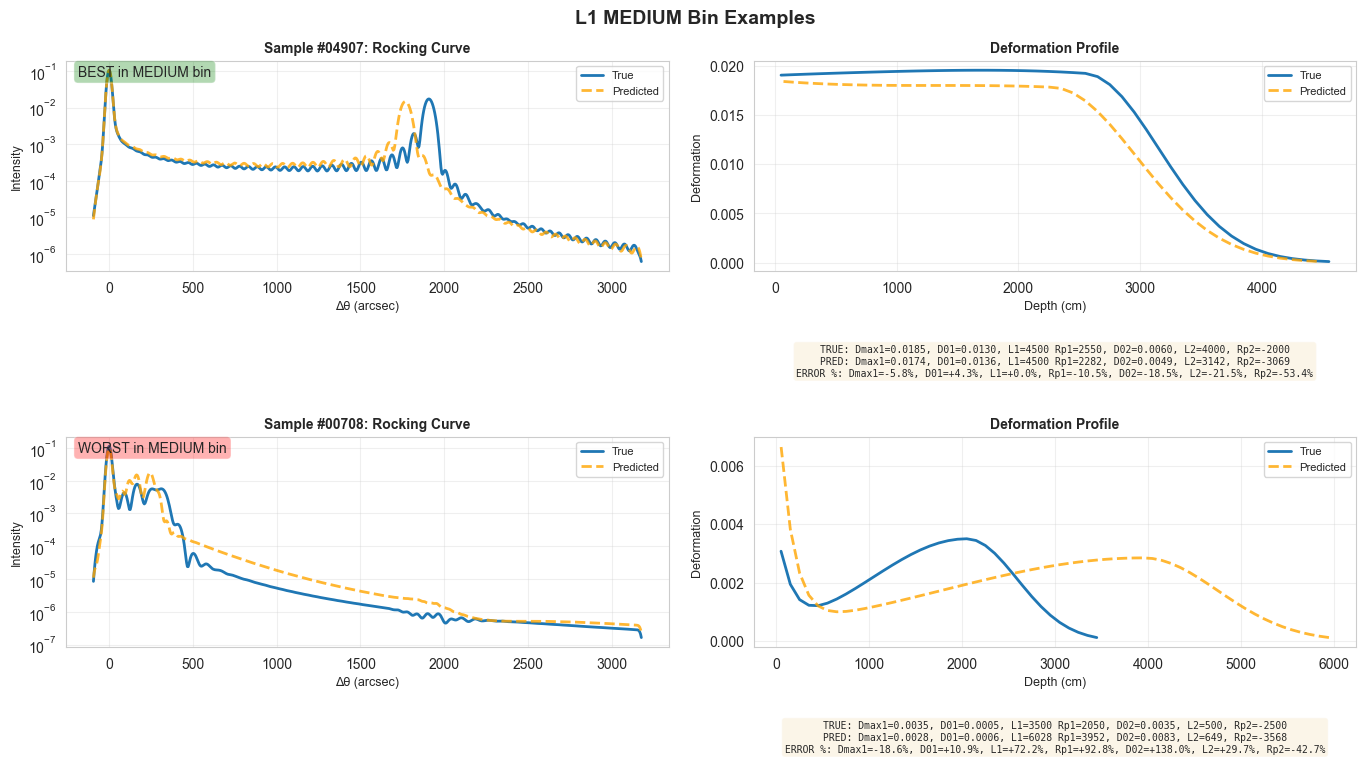


HIGH bin (4.833e-05 to 7.000e-05):
  Samples: 4077
  Avg error: 7.477329e-06
  ✅ Saved: bin_L1_HIGH.png


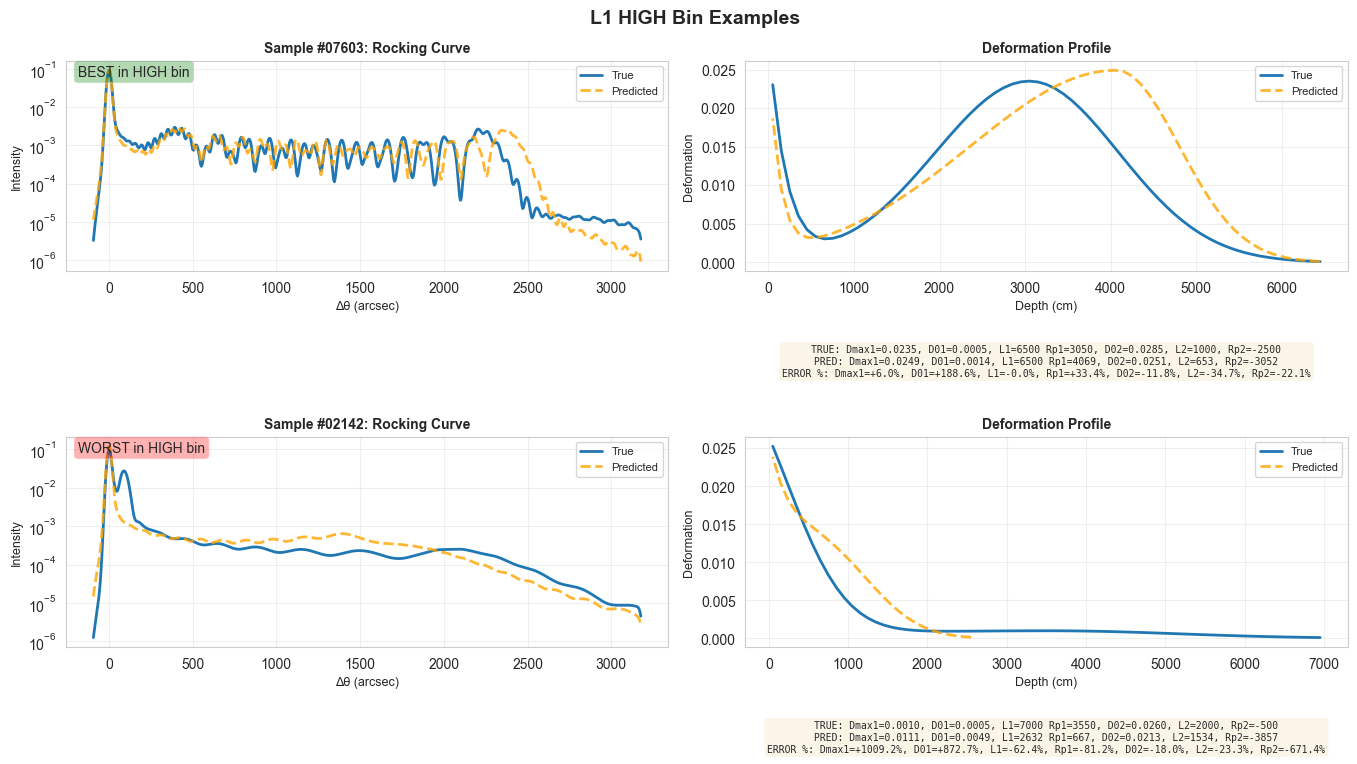




📦 BINNING ANALYSIS: Rp2 (grouped into 3 bins)


LOW bin (-6.500e-05 to -4.333e-05):
  Samples: 3334
  Avg error: 1.919443e-05
  ✅ Saved: bin_Rp2_LOW.png


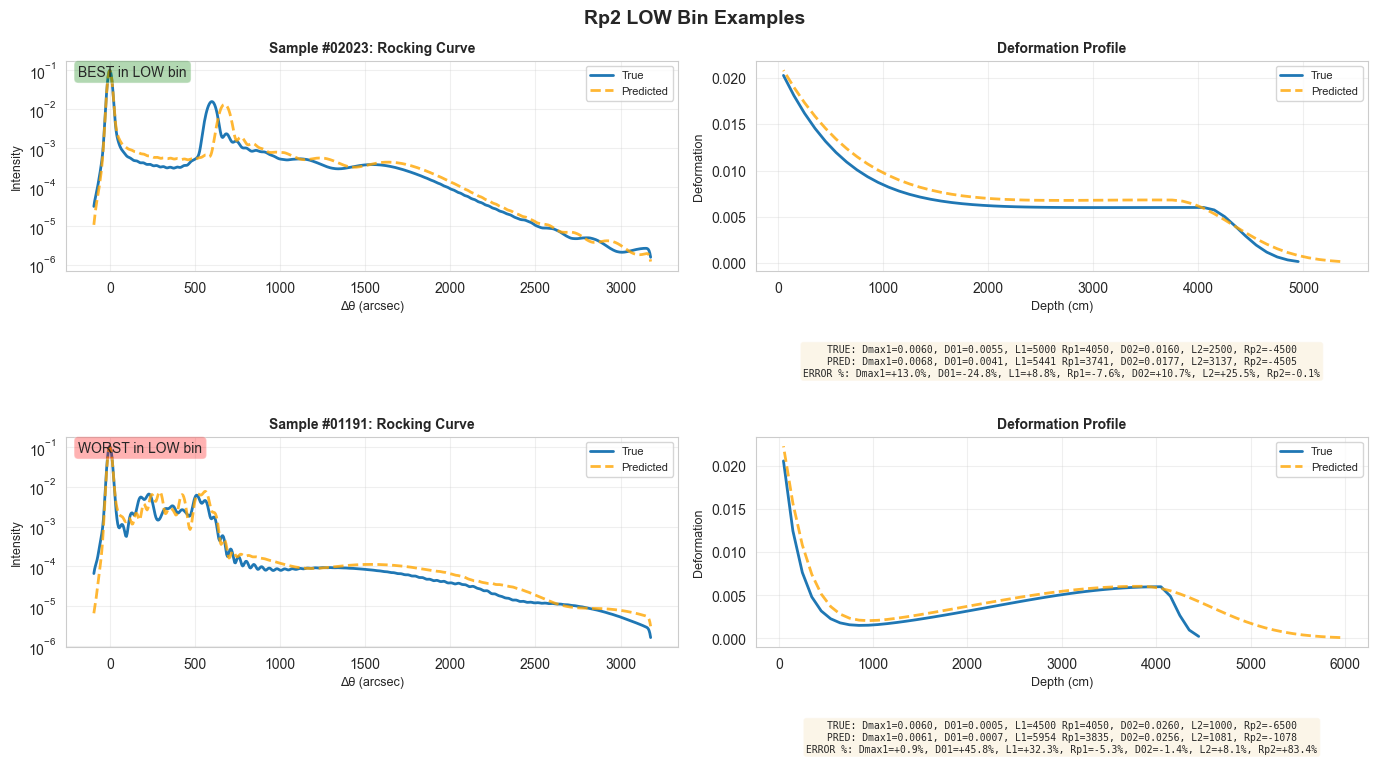


MEDIUM bin (-4.333e-05 to -2.167e-05):
  Samples: 3333
  Avg error: 6.231964e-06
  ✅ Saved: bin_Rp2_MEDIUM.png


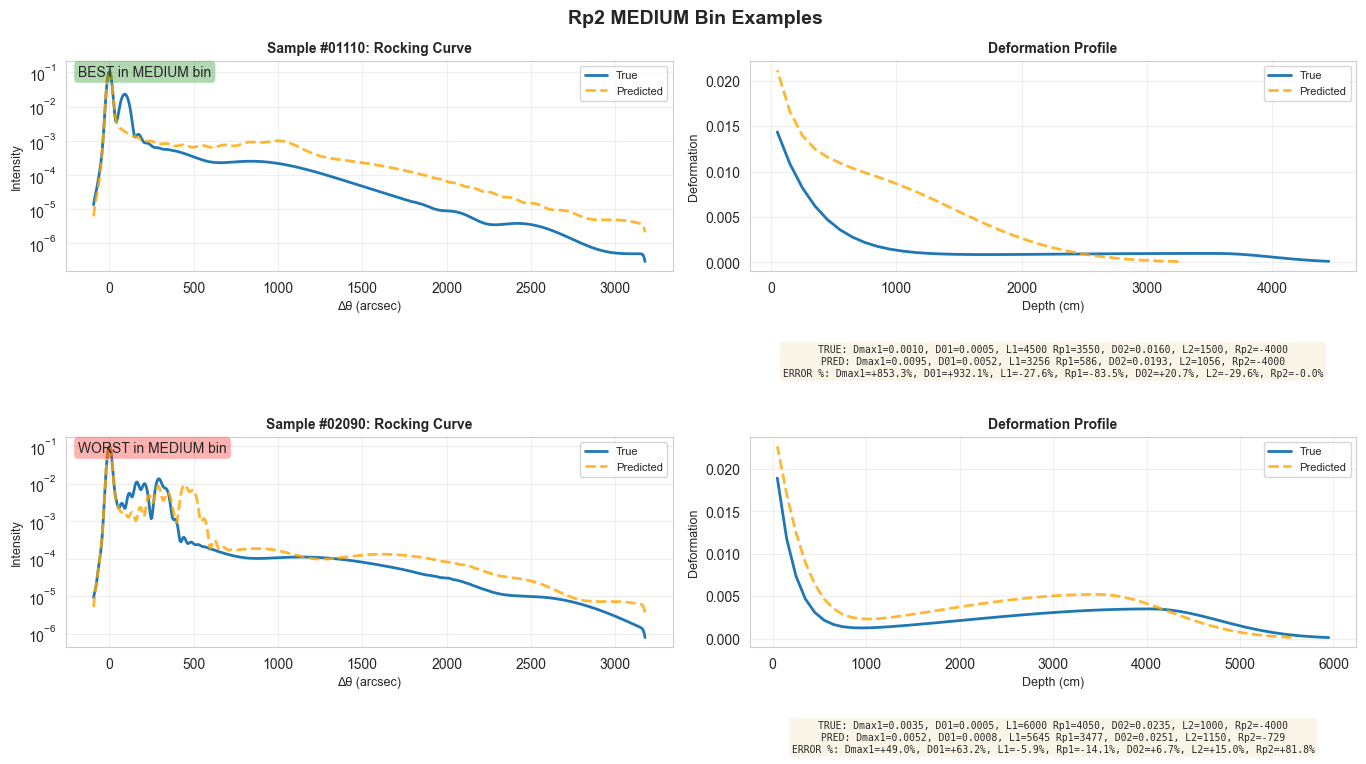


HIGH bin (-2.167e-05 to 0.000e+00):
  Samples: 3333
  Avg error: 2.037961e-05
  ✅ Saved: bin_Rp2_HIGH.png


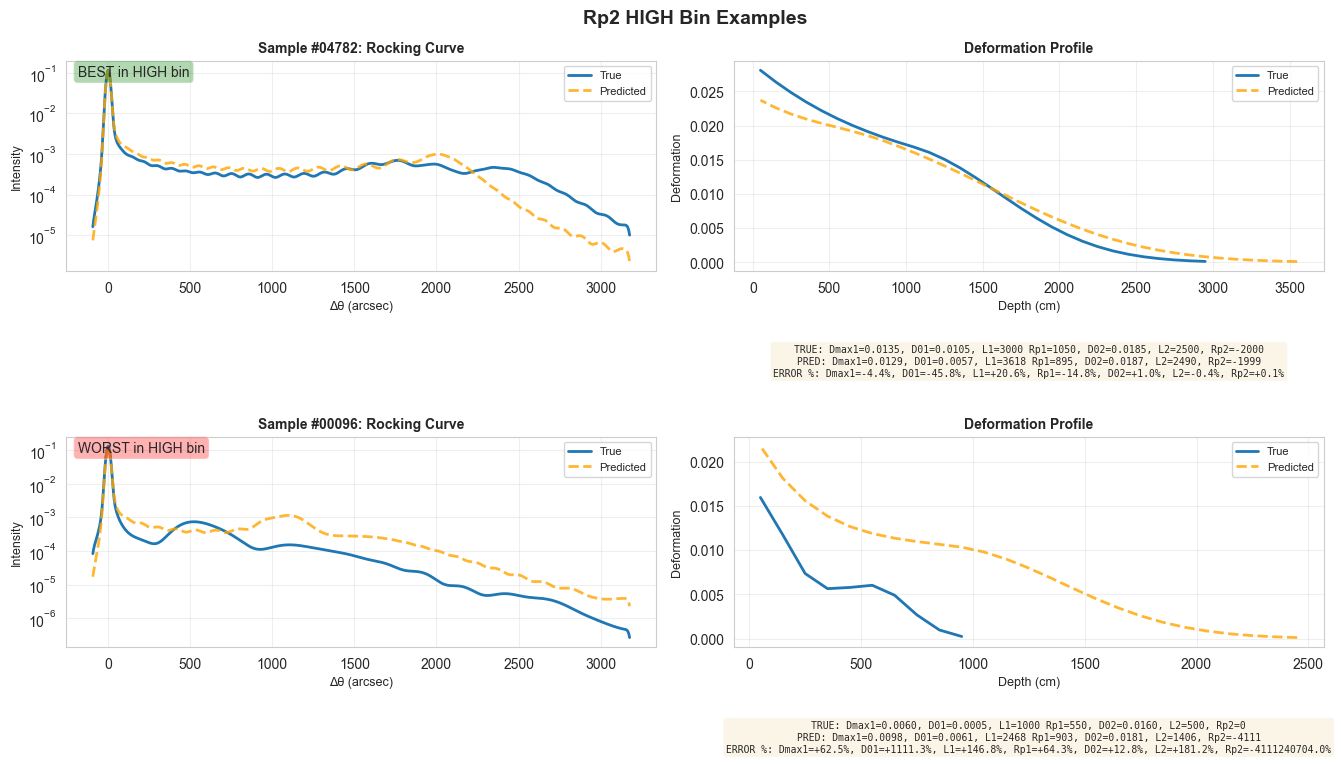

In [31]:
def bin_analysis_with_visuals(X, Theta_hat, abs_err, param_name, n_bins=3, examples_per_bin=2, dl=100e-8):
    """
    Analyze errors grouped by parameter bins and show visual examples.
    For each bin: show best and worst case.
    """
    param_idx = PARAM_NAMES.index(param_name)
    param_values = X[:, param_idx]
    
    # Create bins
    param_range = RANGES[param_name]
    bins = np.linspace(param_range[0], param_range[1], n_bins + 1)
    labels = ['LOW', 'MEDIUM', 'HIGH'][:n_bins]
    
    # Assign bins
    bin_indices = np.digitize(param_values.numpy(), bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    print(f"\n{'='*80}")
    print(f"📦 BINNING ANALYSIS: {param_name} (grouped into {n_bins} bins)")
    print(f"{'='*80}\n")
    
    # For each bin
    for bin_idx, bin_label in enumerate(labels):
        # Get samples in this bin
        mask = bin_indices == bin_idx
        bin_samples = np.where(mask)[0]
        
        if len(bin_samples) == 0:
            print(f"\n{bin_label} bin: No samples")
            continue
        
        # Calculate statistics for this bin
        bin_errors = abs_err[bin_samples, param_idx]
        avg_error = bin_errors.mean().item()
        
        print(f"\n{bin_label} bin ({bins[bin_idx]:.3e} to {bins[bin_idx+1]:.3e}):")
        print(f"  Samples: {len(bin_samples)}")
        print(f"  Avg error: {avg_error:.6e}")
        
        # Find best and worst in this bin
        sorted_indices = torch.argsort(bin_errors)
        best_in_bin = bin_samples[sorted_indices[0]]
        worst_in_bin = bin_samples[sorted_indices[-1]]
        
        # Visualize best and worst
        fig, axes = plt.subplots(2, 2, figsize=(14, 8))
        
        # Best case
        plot_sample_comparison(
            X[best_in_bin].numpy(), 
            Theta_hat[best_in_bin].numpy(), 
            best_in_bin,
            axes[0, 0], axes[0, 1], dl=dl
        )
        axes[0, 0].text(0.02, 0.98, f'BEST in {bin_label} bin',
                        transform=axes[0, 0].transAxes,
                        fontsize=10, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='green', alpha=0.3))
        
        # Worst case
        plot_sample_comparison(
            X[worst_in_bin].numpy(), 
            Theta_hat[worst_in_bin].numpy(), 
            worst_in_bin,
            axes[1, 0], axes[1, 1], dl=dl
        )
        axes[1, 0].text(0.02, 0.98, f'WORST in {bin_label} bin',
                        transform=axes[1, 0].transAxes,
                        fontsize=10, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
        
        plt.suptitle(f'{param_name} {bin_label} Bin Examples', fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        filename = f'bin_{param_name}_{bin_label}.png'
        # plt.savefig(filename, dpi=150, bbox_inches='tight')
        print(f"  ✅ Saved: {filename}")
        plt.show()
    
    print(f"\n{'='*80}\n")

# Analyze bins for selected parameters
PARAMS_FOR_BINNING = ['L1', 'Rp2']  # Parameters to bin
# PARAMS_FOR_BINNING = PARAM_NAMES  # Uncomment to analyze all

for param_name in PARAMS_FOR_BINNING:
    bin_analysis_with_visuals(X, Theta_hat, abs_err, param_name, n_bins=3, dl=DL)

## 7️⃣ Summary Statistics

In [32]:
print(f"\n{'='*80}")
print("📊 STATISTICAL SUMMARY")
print(f"{'='*80}\n")

summary_data = []
for j, param_name in enumerate(PARAM_NAMES):
    errors = abs_err[:, j].numpy()
    rel_errors = (errors / (np.abs(X[:, j].numpy()) + 1e-12)) * 100
    
    summary_data.append({
        'Parameter': param_name,
        'Mean Abs': f"{errors.mean():.3e}",
        'Median Abs': f"{np.median(errors):.3e}",
        'Std': f"{errors.std():.3e}",
        'Mean %': f"{rel_errors.mean():.1f}%",
        'Max': f"{errors.max():.3e}",
        'P95': f"{np.percentile(errors, 95):.3e}"
    })

df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))
print(f"\n{'='*80}")
print("✅ Analysis complete!")
print(f"{'='*80}")


📊 STATISTICAL SUMMARY

Parameter  Mean Abs Median Abs       Std       Mean %       Max       P95
    Dmax1 1.689e-03  1.175e-03 1.835e-03        26.2% 1.742e-02 5.409e-03
      D01 2.327e-03  1.649e-03 2.198e-03       106.8% 1.679e-02 6.759e-03
       L1 7.229e-06  6.263e-06 5.183e-06        18.6% 4.393e-05 1.683e-05
      Rp1 3.922e-06  2.840e-06 3.904e-06        70.7% 4.693e-05 1.068e-05
      D02 2.729e-03  2.111e-03 2.319e-03        57.2% 1.806e-02 7.396e-03
       L2 6.538e-06  4.935e-06 5.659e-06        38.7% 4.172e-05 1.776e-05
      Rp2 1.527e-05  1.448e-05 9.676e-06 158574688.0% 5.422e-05 3.149e-05

✅ Analysis complete!
